In [358]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

warnings.filterwarnings('ignore')

### 用户基本信息表

In [359]:
user_info_cloumns = ['user_id', 'sex', 'occupation', 'education', 'marriage', 'household_type']
user_info = pd.read_table("../data/train/user_info_train.txt", names=user_info_cloumns, sep=',')

In [360]:
user_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55596 entries, 0 to 55595
Data columns (total 6 columns):
user_id           55596 non-null int64
sex               55596 non-null int64
occupation        55596 non-null int64
education         55596 non-null int64
marriage          55596 non-null int64
household_type    55596 non-null int64
dtypes: int64(6)
memory usage: 2.5 MB


### 银行流水记录  

In [361]:
bank_detail = pd.read_table("../data/train/bank_detail_train.txt", sep=',')

In [362]:
bank_detail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6070197 entries, 0 to 6070196
Data columns (total 5 columns):
uid         int64
timespan    int64
type        int64
amount      float64
markup      int64
dtypes: float64(1), int64(4)
memory usage: 231.6 MB


In [363]:
bank_detail.rename(columns={'uid':'user_id', 'timespan':'time', 'type':'deal_type', 
                            'amount':'deal_amount', 'markup':'wage_type'}, 
                   inplace=True)

### 用户浏览记录表

In [364]:
browse_history_columns = ['user_id', 'time', 'browse_behavior', 'browse_subbehavior']
browse_history = pd.read_table("../data/train/browse_history_train.txt", names=browse_history_columns, sep=',')

In [365]:
browse_history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22919547 entries, 0 to 22919546
Data columns (total 4 columns):
user_id               int64
time                  int64
browse_behavior       int64
browse_subbehavior    int64
dtypes: int64(4)
memory usage: 699.4 MB


### 信用卡账单记录  

In [366]:
bill_detail_columns = ['user_id', 'time', 'bank_id', 'previous_bills', 'previous_repayment', 'creditCardQuota', 
                       'current_balance', 'current_MinRepay', 'consume_times', 'current_bills', 'adjust_money',
                       'revolving_interest', 'available_money', 'cash_Advance_Limit', 'repayment_status']
bill_detail = pd.read_table("../data/train/bill_detail_train.txt", names=bill_detail_columns, sep=',')

In [367]:
bill_detail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2338118 entries, 0 to 2338117
Data columns (total 15 columns):
user_id               int64
time                  int64
bank_id               int64
previous_bills        float64
previous_repayment    float64
creditCardQuota       float64
current_balance       float64
current_MinRepay      float64
consume_times         int64
current_bills         float64
adjust_money          float64
revolving_interest    float64
available_money       float64
cash_Advance_Limit    float64
repayment_status      int64
dtypes: float64(10), int64(5)
memory usage: 267.6 MB


### 放款时间信息

In [368]:
loan_time_columns = ['user_id', 'time']
loan_time = pd.read_table("../data/train/loan_time_train.txt", names=loan_time_columns, sep=',')

### 用户逾期记录   

In [369]:
overdue_columns = ['user_id', 'isOverdue']
overdue = pd.read_table("../data/train/overdue_train.txt", names=overdue_columns, sep=',')

# EDA

## 周期性时间提取

In [370]:
# import time

# table_names = [bank_detail, browse_history, bill_detail, loan_time]

# for value in table_names:
#     value['month'] = value['time'].apply(lambda x: int(time.strftime("%m", time.localtime(x))))
#     value['day'] = value['time'].apply(lambda x: int(time.strftime("%d", time.localtime(x))))
#     value.drop('time', axis=1, inplace=True)

## 数据筛选

- 合并放款时间信息表与银行流水信息表，筛选出流水时间 <= 放款时间的记录，去重，筛选用户

In [371]:
bankAndLoan = pd.merge(left=bank_detail, right=loan_time, how='left', on='user_id')

In [372]:
temp = bankAndLoan.loc[bankAndLoan['time_x'] <= bankAndLoan['time_y']]
bank_user = temp.drop_duplicates(subset=['user_id'], keep='first')[['user_id']]

- 合并用户浏览行为表与放款时间信息表，筛选出浏览时间 <= 放款时间的记录，去重，筛选用户

In [373]:
browseAndLoan = pd.merge(left=browse_history, right=loan_time, how='left', on='user_id')

In [374]:
temp = browseAndLoan.loc[browseAndLoan['time_x'] <= browseAndLoan['time_y']]
browse_user = temp.drop_duplicates(subset=['user_id'], keep='first')[['user_id']]

- 合并放款时间信息表与信用卡账单记录表，筛选出账单时间 <= 放款时间的记录，去重，筛选用户

In [375]:
billAndLoan = pd.merge(left=bill_detail, right=loan_time, how='left', on='user_id')

In [376]:
temp = billAndLoan.loc[billAndLoan['time_x'] <= billAndLoan['time_y']]
bill_user = temp.drop_duplicates(subset=['user_id'], keep='first')[['user_id']]

- 合并以上共有id

In [377]:
bankAndBrowse = pd.merge(left=bank_user, right=browse_user, how='inner', on='user_id')
nunique_id = pd.merge(left=bankAndBrowse, right=bill_user, how='inner', on='user_id')

### 银行流水记录表

#### 筛选银行流水记录表中的数据

In [378]:
bank_select = pd.merge(left=nunique_id, right=bank_detail, how='inner', on='user_id')

In [379]:
bank_select.head()

,user_id,time,deal_type,deal_amount,wage_type
0,6965,5894316387,0,13.756664,0
1,6965,5894321388,1,13.756664,0
2,6965,5897553564,0,14.449810,0
3,6965,5897563463,1,10.527763,0
4,6965,5897564598,1,13.651303,0


#### 构建统计特征

- 流水记录应该是对应每一笔交易的信息  
- 注意合并后会产生缺失值，例如某用户没有类型 0 的交易，也就没有相应的统计特征值

- 总收入

In [380]:
deal_type_0 = bank_select[bank_select['deal_type'] == 0].groupby(['user_id'], sort=False, as_index=False)
total_income = deal_type_0['deal_amount'].agg({'income_num': 'count', 'income_amount': 'sum'})

- 总支出

In [381]:
deal_type_1 = bank_select[bank_select['deal_type'] == 1].groupby(['user_id'], sort=False, as_index=False)
total_expen = deal_type_1['deal_amount'].agg({'expen_num': 'count', 'expen_amount': 'sum'})

- 工资收入统计

In [382]:
wage_type_1 = bank_select[bank_select['wage_type'] == 1].groupby(['user_id'], sort=False, as_index=False)
wage_income = wage_type_1['deal_amount'].agg({'wages_num': 'count', 'wages_amount': 'sum'})

- 非工资性收入统计（非工资性收入，是指劳动者所取得的不属于工资范围的收入）

In [383]:
wage_type_0 = bank_select[(bank_select['wage_type'] == 0) & (bank_select['deal_type'] == 0)].groupby(['user_id'], 
                                                                                                     sort=False, as_index=False)
non_wage_income = wage_type_0['deal_amount'].agg({'non_wages_num': 'count', 'non_wages_amount': 'sum'})

#### 合并数据

In [384]:
total_income = pd.merge(left=nunique_id, right=total_income, how='left', on='user_id')
total_income = total_income.fillna(0)

In [385]:
total_expen = pd.merge(left=nunique_id, right=total_expen, how='left', on='user_id')
total_expen = total_expen.fillna(0)

In [386]:
wage_income = pd.merge(left=nunique_id, right=wage_income, how='left', on='user_id')
wage_income = wage_income.fillna(0)

In [387]:
non_wage_income = pd.merge(left=nunique_id, right=non_wage_income, how='left', on='user_id')
non_wage_income = non_wage_income.fillna(0)

In [388]:
bank_train = total_income.merge(total_expen)
bank_train = bank_train.merge(wage_income)
bank_train = bank_train.merge(non_wage_income)

- 数据高度相关（总收入 = 工资性收入 + 非工资性收入），可以考虑drop部分或者换表示方式，例如是否有非工资性收入特征  
- 平均每笔交易金额做特征是否有意义？  
- 部分用户既有工资性收入也有非工资性收入，是否可做为特征？

In [391]:
bank_train.head()

,user_id,income_num,income_amount,expen_num,expen_amount,wages_num,wages_amount,non_wages_num,non_wages_amount
0,6965,75.0,972.850228,289.0,3234.531975,0.0,0.000000,75.0,972.850228
1,1265,125.0,1708.206195,294.0,3662.457063,0.0,0.000000,125.0,1708.206195
2,2583,213.0,2736.475318,618.0,7064.310678,0.0,0.000000,213.0,2736.475318
3,29165,189.0,2277.607807,473.0,5099.861165,14.0,202.630532,175.0,2074.977275
4,2443,252.0,3020.288782,341.0,3762.790364,0.0,0.000000,252.0,3020.288782


- income_num : 放款前用户收入笔数  
- income_amount: 放款前用户收入总计  
- expen_num: 放款前用户支出笔数  
- expen_amount: 放款前用户支出总计  
- wages_num: 放款前用户工资收入笔数  
- wages_amount: 放款前用户工资收入总计  
- non_wages_num: 放款前用户非工资性收入笔数  
- non_wages_amount: 放款前用户非工资性收入总计  

#### 相关性分析

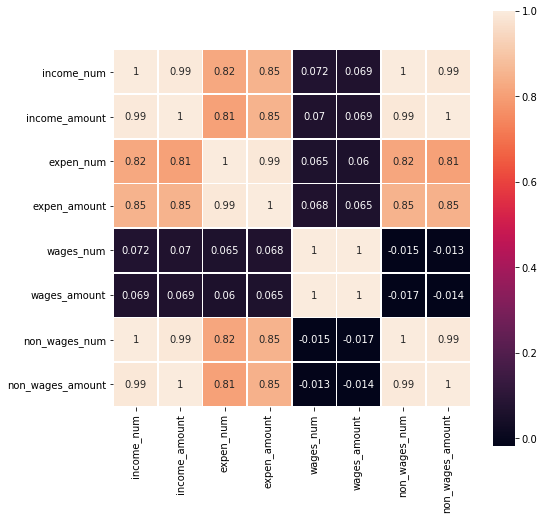

In [392]:
bank_train_corr = bank_train.drop('user_id', axis=1).corr()
plt.subplots(figsize=(8, 8))
sns.heatmap(bank_train_corr, square=True, annot=True, linewidths=0.5)
plt.show()

- 特征高度相关，drop部分特征  

In [396]:
# 平均每次支出
bank_train['per_expen'] = bank_train['expen_amount'] // bank_train['expen_num']

In [397]:
# 平均每次收入（由于相关度太高暂时舍弃，后期可测试）
bank_train['per_income'] = bank_train['income_amount'] // bank_train['income_num']

In [398]:
# # 平均每笔工资
# bank_train['per_wage'] = bank_train['wages_amount'] // bank_train['wages_num']
# # 存在wages_num为0的情况，直接除会出现缺失值

In [399]:
bank_train.drop(['income_num', 'expen_num', 'wages_num', 'non_wages_num', 'non_wages_amount', 'income_amount'], 
               axis=1, inplace=True)

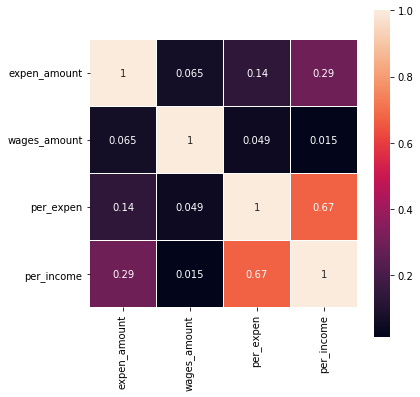

In [400]:
bank_train_corr = bank_train.drop('user_id', axis=1).corr()
plt.subplots(figsize=(6, 6))
sns.heatmap(bank_train_corr, square=True, annot=True, linewidths=0.5)
plt.show()

### 信用卡账单记录表

In [403]:
bill_select = pd.merge(left=nunique_id, right=bill_detail, how='inner', on='user_id')

In [404]:
bill_select['repayment_status'].value_counts()

0    353084
1        67
Name: repayment_status, dtype: int64

- 还款状态特征取值严重偏斜  
- bank_id是分类型变量  
- 时间戳是唯一标识

#### 构建统计特征

In [405]:
# from sklearn.preprocessing import LabelEncoder

# cata_encoder = LabelEncoder()
# cata_encoder.fit(bill_select['bank_id'])
# bill_select['bank_id'] = cata_encoder.transform(bill_select['bank_id'])

In [406]:
temp = bill_select.groupby(['user_id'], sort=False, as_index=False)
toGet_mean = ['previous_bills', 'previous_repayment', 'creditCardQuota', 'current_balance', 
              'current_MinRepay', 'current_bills', 'adjust_money', 'revolving_interest', 
              'available_money', 'cash_Advance_Limit']
mean_process = temp[toGet_mean].mean()

In [407]:
# 统计消费次数
consume_count = bill_select.groupby(['user_id'], sort=False, as_index=False)['consume_times'].count()

In [408]:
# 统计不用用户交易过的银行数
bank_count = bill_select.groupby(['user_id'], as_index=False)['bank_id'].agg({'bankNum': 'nunique'})

#### 合并数据

In [409]:
bill_train = pd.merge(nunique_id, consume_count, how='inner', on='user_id')
bill_train = bill_train.merge(bank_count, on='user_id')
bill_train = bill_train.merge(mean_process, on='user_id')

#### 相关性分析

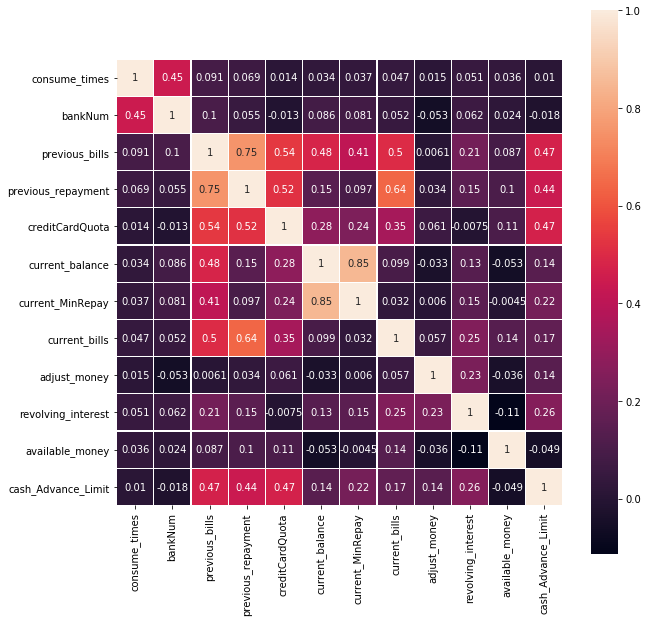

In [410]:
bill_train_corr = bill_train.drop('user_id', axis=1).corr()
plt.subplots(figsize=(10, 10))
sns.heatmap(bill_train_corr, square=True, annot=True, linewidths=0.3)
plt.show()

#### 业务背景下的特征

In [411]:
# 上期还款差额
bill_train['pre_payBalance'] = bill_train['previous_bills'] - bill_train['previous_repayment']

In [412]:
# 上期账单最低还款金额（取上期账单金额的10%）
bill_train['pre_MinRepay'] = bill_train['previous_bills'] * 0.1

In [413]:
# 本期应还金额
bill_train['cur_should_pay'] = (bill_train['previous_bills'] - bill_train['previous_repayment'] + 
                                bill_train['current_bills'] - bill_train['adjust_money'] + 
                                bill_train['revolving_interest'])

In [414]:
# 上期还款差额二值化
# 互斥特征：本期调整金额 与 循环利息，0代表有调整金额，1代表有循环利息
bill_train['pre_diffLabel'] = 0
bill_train.loc[bill_train['pre_payBalance'] > 0, 'pre_diffLabel'] = 1

- !!! 该特征有问题  
- 本期调整金额与循环利息逻辑上是互斥，但这里数据上却不是，因为在构建bill_train这张表的时候对部分特征做了均值，后期要重新处理

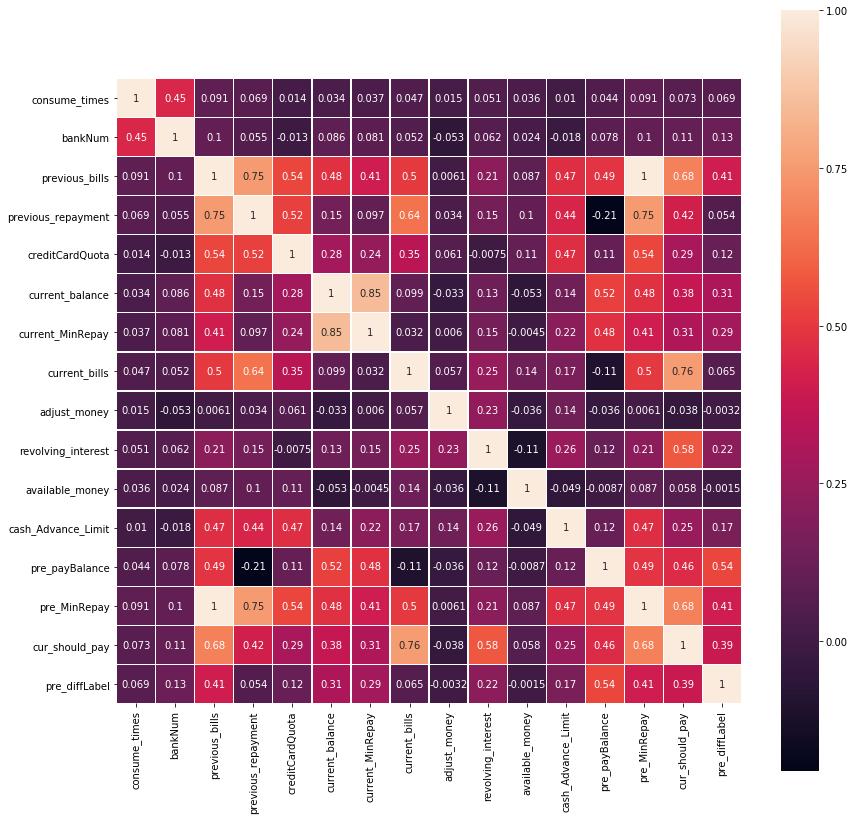

In [415]:
bill_train_corr = bill_train.drop('user_id', axis=1).corr()
plt.subplots(figsize=(14, 14))
sns.heatmap(bill_train_corr, square=True, annot=True, linewidths=0.3)
plt.show()

In [416]:
bill_feat_drop = ['cash_Advance_Limit', 'previous_bills', 'previous_repayment', 'current_balance', 
                  'cur_should_pay', 'pre_MinRepay']
bill_train.drop(bill_feat_drop, axis=1, inplace=True)

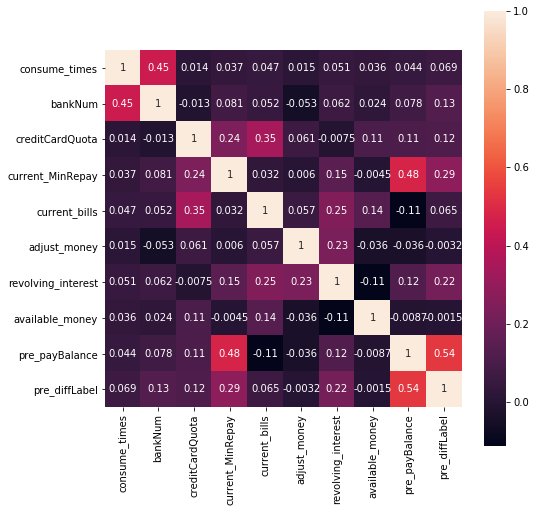

In [417]:
bill_train_corr = bill_train.drop('user_id', axis=1).corr()
plt.subplots(figsize=(8, 8))
sns.heatmap(bill_train_corr, square=True, annot=True)
plt.show()

### 用户浏览记录表

In [418]:
browse_select = pd.merge(nunique_id, browse_history, how='inner', on='user_id')

In [419]:
temp = browse_select.groupby(['user_id'], sort=False, as_index=False)
behavior_count = temp['browse_behavior'].agg({'behavior_counts': 'count'})
# subbehavior_count = temp['browse_subbehavior'].agg({'subbehavior_counts': 'count'})
# 用户子行为的计数总数和用户行为的计数一样，是用户行为更细粒度的划分吗？

In [420]:
browse_train = pd.merge(nunique_id, behavior_count, how='inner', on='user_id')

### 用户信息表和逾期记录表

In [421]:
overdue_train = pd.merge(nunique_id, overdue, how='inner', on='user_id')
user_train = pd.merge(nunique_id, user_info, how='inner', on='user_id')

### 合并5张表

In [422]:
part_train = user_train.merge(bank_train)
part_train = part_train.merge(bill_train)
part_train = part_train.merge(browse_train)
part_train = part_train.merge(overdue_train)

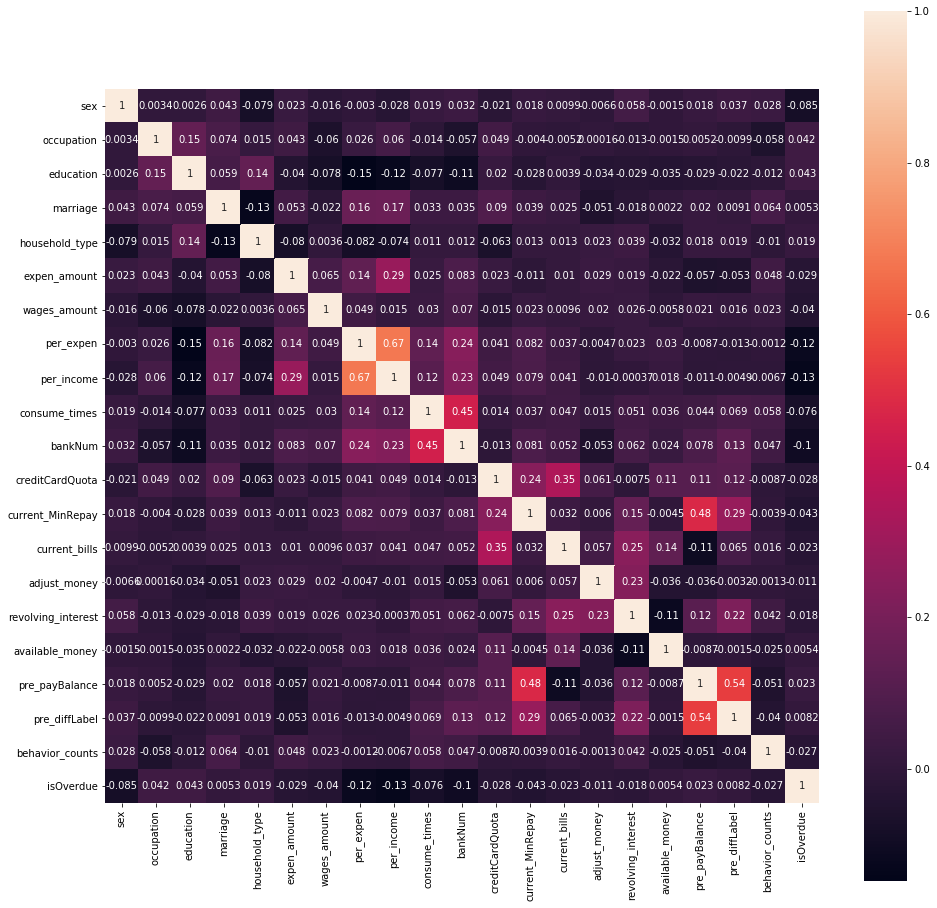

In [423]:
part_train_corr = part_train.drop('user_id', axis=1).corr()
plt.subplots(figsize=(16, 16))
sns.heatmap(part_train_corr, square=True, annot=True)
plt.show()

## 缺失值填充

In [427]:
part_train.isnull().sum()

user_id               0
sex                   0
occupation            0
education             0
marriage              0
household_type        0
expen_amount          0
wages_amount          0
per_expen             5
per_income            1
consume_times         0
bankNum               0
creditCardQuota       0
current_MinRepay      0
current_bills         0
adjust_money          0
revolving_interest    0
available_money       0
pre_payBalance        0
pre_diffLabel         0
behavior_counts       0
isOverdue             0
dtype: int64

In [428]:
part_train['per_expen'] = part_train['per_expen'].fillna(part_train['per_expen'].mean())
part_train['per_income'] = part_train['per_income'].fillna(part_train['per_income'].mean())

## 特征选择

In [438]:
feat_labels = ['sex', 'occupation', 'education', 'marriage', 'household_type', 'expen_amount', 
               'wages_amount', 'per_expen', 'per_income', 'consume_times', 'bankNum', 'creditCardQuota', 
               'current_MinRepay', 'current_bills', 'adjust_money', 'revolving_interest', 'available_money', 
               'pre_payBalance', 'pre_diffLabel', 'behavior_counts']

In [431]:
X_train = part_train.drop(['user_id', 'isOverdue'], axis=1).values
y_train = part_train['isOverdue']

### 使用随机森林进行特征选择

In [448]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=1000, random_state=1996, n_jobs=-1)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=1996, verbose=0,
            warm_start=False)

In [473]:
pd.DataFrame({'features': feat_labels, 'importance': rf_clf.feature_importances_}).sort_values('importance', ascending=False)

,features,importance
17,pre_payBalance,0.100313
5,expen_amount,0.096663
12,current_MinRepay,0.092519
9,consume_times,0.091617
19,behavior_counts,0.088529
11,creditCardQuota,0.083200
13,current_bills,0.078744
15,revolving_interest,0.038929
6,wages_amount,0.037839
8,per_income,0.037471


### 卡方检验

In [469]:
from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(f_classif, k=20)
selector.fit(X_train, y_train)

SelectKBest(k=20, score_func=<function f_classif at 0x0000015A81E586A8>)

In [470]:
pd.DataFrame({'features': feat_labels, 'f_classif': selector.scores_}).sort_values('f_classif', ascending=False)

,features,f_classif
8,per_income,99.035239
7,per_expen,83.666850
10,bankNum,58.258765
0,sex,41.774961
9,consume_times,33.092187
2,education,10.711238
12,current_MinRepay,10.682181
1,occupation,10.177563
6,wages_amount,9.319849
5,expen_amount,4.720279


In [474]:
part_train.drop(['pre_diffLabel'], axis=1, inplace=True)

# 模型构建

In [479]:
X = part_train.drop(['user_id', 'isOverdue'], axis=1).values
y = part_train['isOverdue']